In [1]:
import os
import cv2
import shutil
import random
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
# resize and organize images into a new directory for training
sdir = 'Plants_2'
img_size = (200,300)

working_dir = r'./'
dstdir = os.path.join(working_dir, 'resizedmerged')
if os.path.isdir(dstdir):
    shutil.rmtree(dstdir)
os.mkdir(dstdir)

filepaths = []
labels = []
plant_list = sorted(os.listdir(sdir))    
for plant in plant_list:
    plant_path = os.path.join(sdir, plant)
    dst_plant_path = os.path.join(dstdir, plant)
    os.mkdir(dst_plant_path)
    classlist = sorted(os.listdir(plant_path))
    
    for cl in classlist:
        classpath = os.path.join(plant_path, cl)
        dst_classpath = os.path.join(dst_plant_path, cl)
        os.mkdir(dst_classpath)

        # Only process if classpath is a directory
        if os.path.isdir(classpath):  # Ensure classpath is a directory
            flist = sorted(os.listdir(classpath))
            desc = f'{plant:25s}-{cl:9s}'
            
            for f in tqdm(flist, ncols=130, desc=desc, unit='files', colour='blue'):
                fpath = os.path.join(classpath, f)
                dst_fpath = os.path.join(dst_classpath, f)
                
                # if the file exists then resize and save
                if os.path.isfile(fpath):  # Ensure fpath is a file
                    filepaths.append(dst_fpath)
                    img = cv2.imread(fpath)
                    img = cv2.resize(img, img_size)
                    cv2.imwrite(dst_fpath, img)
                    labels.append(plant + '-' + cl)

            
Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name = 'labels')
df = pd.concat([Fseries, Lseries], axis = 1)

test                     -Alstonia Scholaris diseased (P2a): 100%|███████████████████████████████| 5/5 [00:00<00:00,  8.95files/s]
test                     -Alstonia Scholaris healthy (P2b): 100%|████████████████████████████████| 5/5 [00:00<00:00, 10.02files/s]
test                     -Jamun healthy (P5a): 100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73files/s]
test                     -Jatropha diseased (P6b): 100%|█████████████████████████████████████████| 5/5 [00:00<00:00,  9.67files/s]
test                     -Mango healthy (P0a): 100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10files/s]
test                     -Pomegranate diseased (P9b): 100%|██████████████████████████████████████| 5/5 [00:00<00:00, 10.25files/s]
test                     -Pomegranate healthy (P9a): 100%|███████████████████████████████████████| 5/5 [00:00<00:00, 10.26files/s]
test                     -Pongamia Pinnata diseased (P7b): 100%|███████████████████

In [ ]:
# save and reload dataset
df.to_csv('data.csv', index = False)

df = pd.read_csv('data.csv')
df['labels'] = df['labels'].apply(lambda x: x.split('-')[1])  # get only the class label


In [ ]:
# split into train, val, test using stratification
df_train, df_test = train_test_split(df, test_size = 0.2, stratify = df['labels'], random_state = 42, shuffle = True)
df_train, df_val = train_test_split(df_train, test_size = 0.2, stratify = df_train['labels'], random_state = 42, shuffle = True)

# just to make sure we use proper folders
df_train = df[df['filepaths'].str.contains('train')]
df_val = df[df['filepaths'].str.contains('val')]
df_test = df[df['filepaths'].str.contains('test')]


In [ ]:
# check class stats
classes = sorted(df_train['labels'].unique())
class_count = len(classes)    
print('number of classes in processed dataset =', class_count)

counts = list(df_train['labels'].value_counts())
print('the maximum files in any class in df_train is ', max(counts), '  the minimum files in any class in df_train is ', min(counts))
print('df_train length: ', len(df_train), '  df_test length: ', len(df_test), '  df_val length: ', len(df_val))

# return df_train, df_test, df_val, classes, class_count
# df_train, df_test, df_val, classes, class_count = make_dataframes(sdir, img_size)

number of classes in processed dataset = 22
the maximum files in any class in df_train is  335   the minimum files in any class in df_train is  67
df_train length:  4274   df_test length:  110   df_val length:  110


In [ ]:
# dataset class used for loading and transforming images
class LeafDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        image = Image.open(img_name)
        label = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

def load_data(df):
    transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


    dataset = LeafDataset(df, transform=transform)
    return dataset

In [ ]:
# encode string labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(classes)
df_train['labels'] = label_encoder.transform(df_train['labels'])
df_test['labels'] = label_encoder.transform(df_test['labels'])
df_val['labels'] = label_encoder.transform(df_val['labels'])

# load datasets
train_dataset = load_data(df_train)
test_dataset = load_data(df_test)
val_dataset = load_data(df_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)

C:\Users\20200306\AppData\Local\Temp\ipykernel_8264\3764728453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['labels'] = label_encoder.transform(df_train['labels'])
C:\Users\20200306\AppData\Local\Temp\ipykernel_8264\3764728453.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['labels'] = label_encoder.transform(df_test['labels'])
C:\Users\20200306\AppData\Local\Temp\ipykernel_8264\3764728453.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [ ]:
# load alexnet with pretrained weights and freeze features
alexnet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
for param in alexnet.features.parameters():
    param.requires_grad = False

num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, len(label_encoder.classes_))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.0005, weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)



In [9]:
num_epochs = 15

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    alexnet.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = alexnet(inputs)
            loss = criterion(outputs, labels.long())
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    train_losses.append(running_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))
    train_accuracies.append((correct_train/total_train) * 100)
    val_accuracies.append((correct_val/total_val) * 100)

    print(
        f"Epoch {epoch+1}/{num_epochs},",
        f"Train Loss: {train_losses[-1]:.4f},",
        f"Val Loss: {val_losses[-1]:.4f},",
        f"Train Acc: {train_accuracies[-1]:.2f}%,",
        f"Val Acc: {val_accuracies[-1]:.2f}%"
    )
    scheduler.step(val_loss)
    
    if epoch > 1 and val_losses[-1] > val_losses[-2] and val_losses[-2] > val_losses[-3]:
        print("Validation loss increasing. Stopping early.")
        break

now = datetime.datetime.now()
timestamp = now.strftime("%m-%d_%H-%M-%S")
model_name = f"alexnet_{timestamp}.pth"
torch.save(alexnet.state_dict(), model_name)

Epoch 1/15, Train Loss: 1.0388, Val Loss: 1.0668, Train Acc: 66.68%, Val Acc: 65.45%
Epoch 2/15, Train Loss: 0.5828, Val Loss: 1.2808, Train Acc: 79.81%, Val Acc: 68.18%
Epoch 3/15, Train Loss: 0.4542, Val Loss: 0.7376, Train Acc: 84.02%, Val Acc: 74.55%
Epoch 4/15, Train Loss: 0.3866, Val Loss: 0.6097, Train Acc: 86.78%, Val Acc: 74.55%
Epoch 5/15, Train Loss: 0.3661, Val Loss: 0.6440, Train Acc: 86.87%, Val Acc: 75.45%
Epoch 6/15, Train Loss: 0.3435, Val Loss: 0.5520, Train Acc: 87.60%, Val Acc: 82.73%
Epoch 7/15, Train Loss: 0.3312, Val Loss: 0.6733, Train Acc: 87.93%, Val Acc: 77.27%
Epoch 8/15, Train Loss: 0.2911, Val Loss: 0.8800, Train Acc: 90.15%, Val Acc: 80.91%
Validation loss increasing. Stopping early.


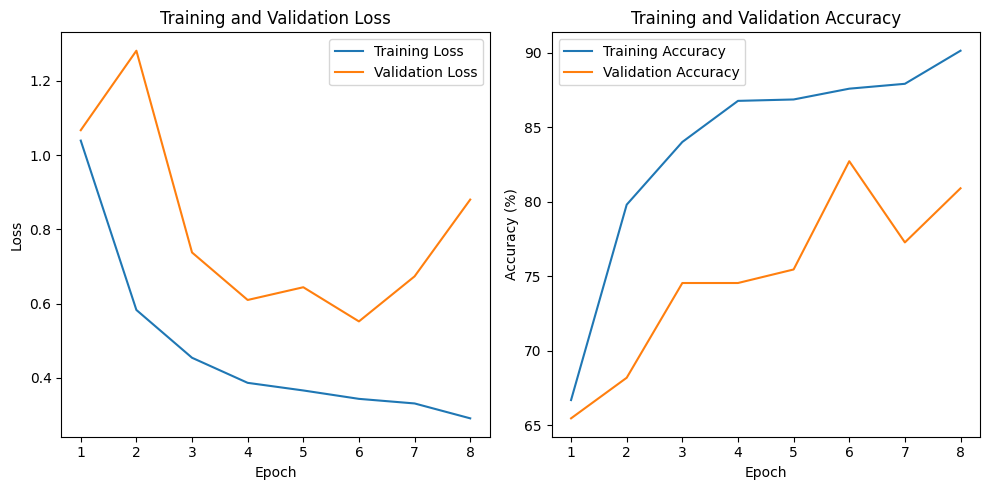

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(train_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(train_losses) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (correct/total) * 100

alexnet.load_state_dict(torch.load(model_name))

test_accuracy = test_model(alexnet, test_loader)
print(f"Test accuracy: {test_accuracy:.2f}%")
        

C:\Users\20200306\AppData\Local\Temp\ipykernel_8264\2949008862.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  alexnet.load_state_dict(torch.load(model_name))


Test accuracy: 90.00%


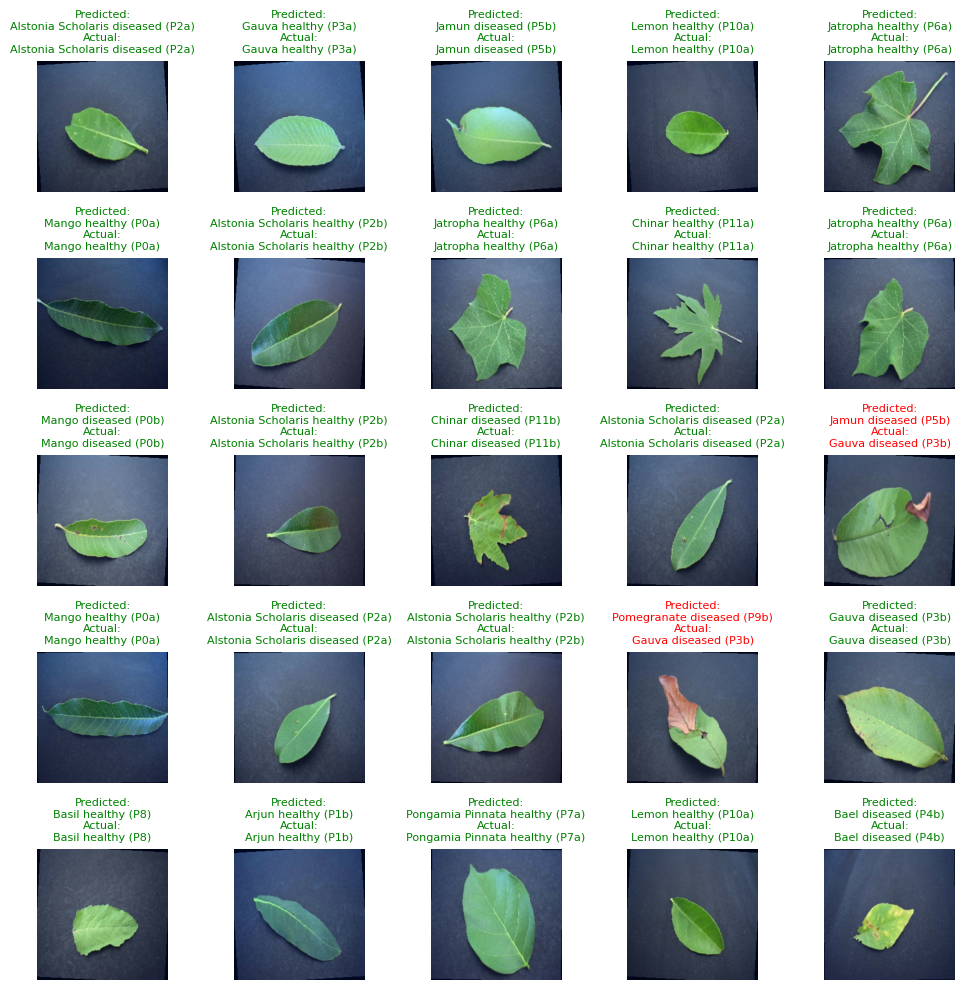

In [17]:
def predict_and_plot(model, test_loader, label_encoder):
    model.eval()
    images_so_far = 0
    fig, axs = plt.subplots(5, 5, figsize=(10, 10))
    
    test_loader.dataset.data = test_loader.dataset.data.sample(frac=1).reset_index(drop=True)
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            for i in range(inputs.size(0)):
                if images_so_far >= 25:
                    break
                ax = axs[images_so_far // 5, images_so_far % 5]
                ax.axis('off')
                color = 'green' if predicted[i] == labels[i] else 'red'
                ax.set_title(f'Predicted:\n{label_encoder.classes_[predicted[i]]}\nActual:\n{label_encoder.classes_[labels[i]]}', color=color, fontsize=8)

                img_np = inputs.cpu().data[i].permute(1, 2, 0).numpy()
                img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
                ax.imshow(img_np)
                images_so_far += 1
                
            if images_so_far >= 25:
                break
    plt.tight_layout()
    plt.show()

predict_and_plot(alexnet, test_loader, label_encoder)